# Problem sheet 06


##  Exercise 6.1: dimensionality reduction on histograms.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [27]:
# load npz file
hist = np.load('hist.npz')


In [28]:
binspec = hist['binspec']
labels = hist['labels']
histograms = hist['data']


### 6.1) Part 1

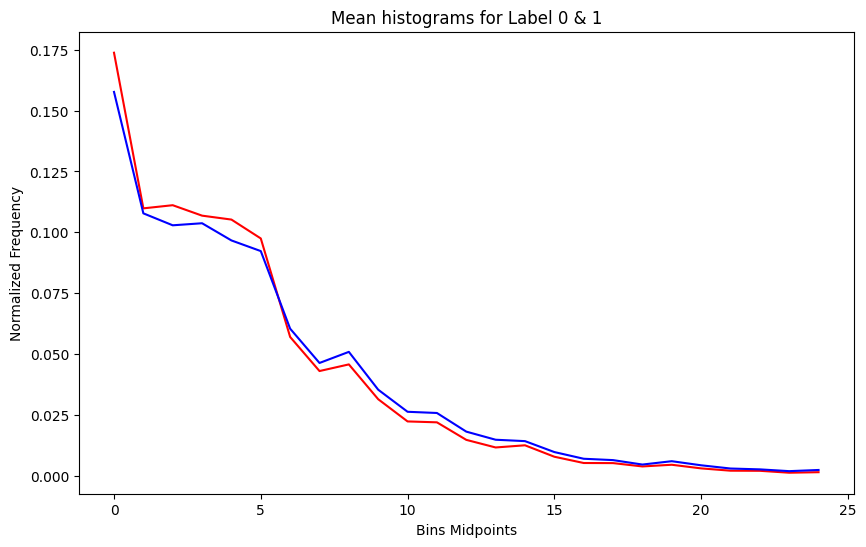

In [29]:
bin_midpoints = (binspec[:-1] + binspec[1:]) / 2

histograms_label_0 = histograms[labels == 0]
histograms_label_1 = histograms[labels == 1]

mean_histograms_label_0 = np.mean(histograms_label_0, axis=0)

mean_histograms_label_1 = np.mean(histograms_label_1, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(mean_histograms_label_0, alpha=1, color= 'red', label='Label 0')
plt.plot(mean_histograms_label_1, alpha=1, color = 'blue', label='Label 1')

plt.title('Mean histograms for Label 0 & 1')
plt.xlabel('Bins Midpoints')
plt.ylabel('Normalized Frequency')
plt.show()


### 6.1 Part 2

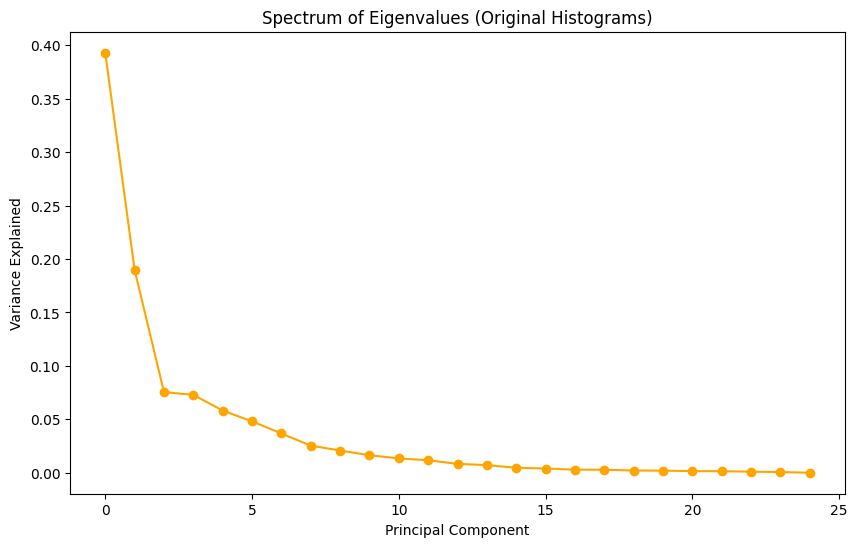

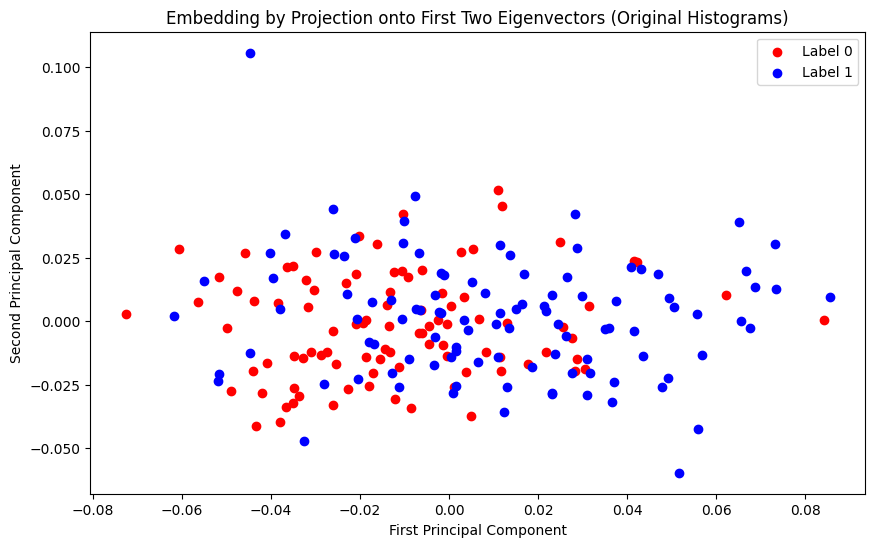

In [30]:
def perform_pca_and_plot(histograms, labels, title_suffix):
    pca = PCA()
    pca.fit(histograms)
    
    plt.figure(figsize=(10, 6))
    plt.plot(pca.explained_variance_ratio_, marker='o', color='orange')
    plt.title(f'Spectrum of Eigenvalues ({title_suffix})')
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained')
    plt.show()

    histograms_pca = pca.transform(histograms)
    histograms_pca_2d = histograms_pca[:, :2]

    plt.figure(figsize=(10, 6))
    plt.scatter(histograms_pca_2d[labels == 0, 0], histograms_pca_2d[labels == 0, 1], alpha=1, label='Label 0', color='red')
    plt.scatter(histograms_pca_2d[labels == 1, 0], histograms_pca_2d[labels == 1, 1], alpha=1, label='Label 1', color='blue')
    plt.title(f'Embedding by Projection onto First Two Eigenvectors ({title_suffix})')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.legend()
    plt.show()
    
    return pca, histograms_pca

pca_original, histograms_pca_original = perform_pca_and_plot(histograms, labels, 'Original Histograms')


### 6.1) Part 3

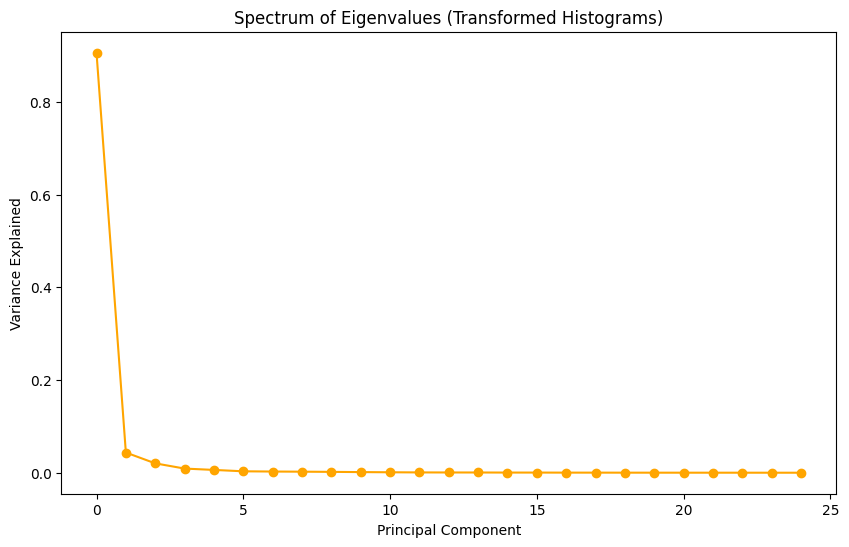

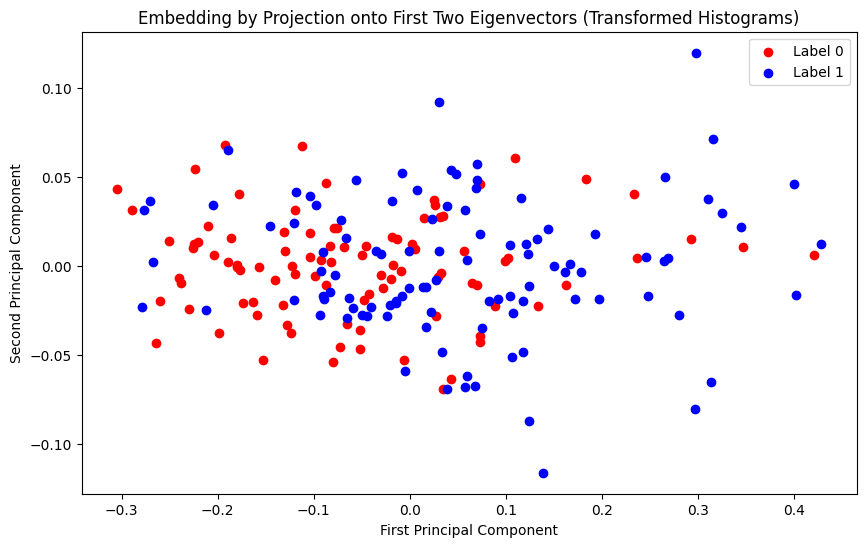

In [31]:
def inverse_cumulative_distance_transform(histogram):
    cdf = np.cumsum(histogram)
    return 1 - cdf

transformed_histograms = np.apply_along_axis(inverse_cumulative_distance_transform, 1, histograms)
pca_transformed, histograms_pca_transformed = perform_pca_and_plot(transformed_histograms, labels, 'Transformed Histograms')


### 6.1) Part 4

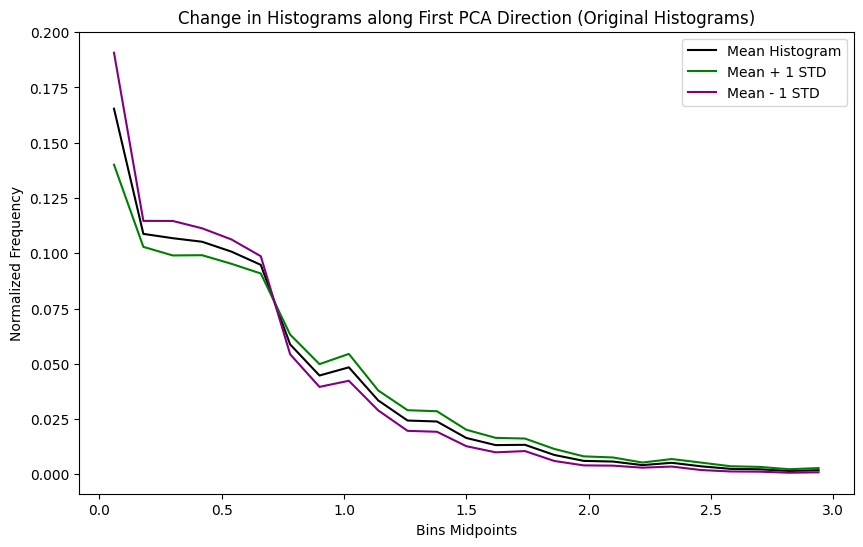

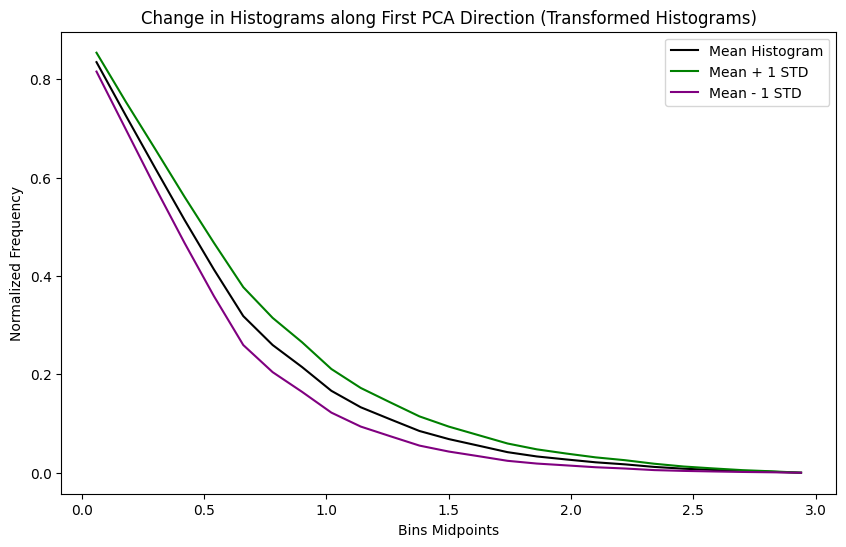

In [32]:
def visualize_pca_changes(histograms, pca, histograms_pca, title_suffix):
    mean_histogram = np.mean(histograms, axis=0)
    first_pc = pca.components_[0]
    std_dev_first_pc = np.std(histograms_pca[:, 0])

    histogram_plus = mean_histogram + std_dev_first_pc * first_pc
    histogram_minus = mean_histogram - std_dev_first_pc * first_pc

    plt.figure(figsize=(10, 6))
    plt.plot(bin_midpoints, mean_histogram, label='Mean Histogram', color='black')
    plt.plot(bin_midpoints, histogram_plus, label='Mean + 1 STD', color='green')
    plt.plot(bin_midpoints, histogram_minus, label='Mean - 1 STD', color='purple')
    plt.title(f'Change in Histograms along First PCA Direction ({title_suffix})')
    plt.xlabel('Bins Midpoints')
    plt.ylabel('Normalized Frequency')
    plt.legend()
    plt.show()

visualize_pca_changes(histograms, pca_original, histograms_pca_original, 'Original Histograms')
visualize_pca_changes(transformed_histograms, pca_transformed, histograms_pca_transformed, 'Transformed Histograms')

#### **Description of Induced Changes:**

- *Original Data:* Moving along the first PCA direction tends to adjust the histogram's shape, highlighting the most significant variance captured by PCA. The changes can represent shifts in peaks and valleys or overall spread.

- *Transformed Data:* The transformed histograms display similar adjustments, but these changes now reflect the cumulative distribution differences captured by PCA. The inverse cumulative distance transform might smooth or amplify specific histogram features, leading to different visual patterns compared to the original histograms.
The transformations highlight different aspects of data variance and can provide insights into the underlying structure of the data based on PCA's most significant components.

## Exercise 6.2: nonlinear manifold learning with UMAP

### Part 1

In [33]:
import glob
import imageio.v2 as imageio
import re
import numpy as np
import umap

image_files = glob.glob("imgs/*")
elevations = []
azimuths = []
image_vectors = []

for file in image_files:

    match = re.search(r'e(\d+)_a(\d+)', file)
    if match:
        elevation = int(match.group(1))
        azimuth = int(match.group(2))
        elevations.append(elevation)
        azimuths.append(azimuth)
    

    image = imageio.imread(file)
    flattened_image = image.flatten()
    image_vectors.append(flattened_image)

elevation_range = (min(elevations), max(elevations))
azimuth_range = (min(azimuths), max(azimuths))

elevation_range, azimuth_range


((20, 59), (0, 87))

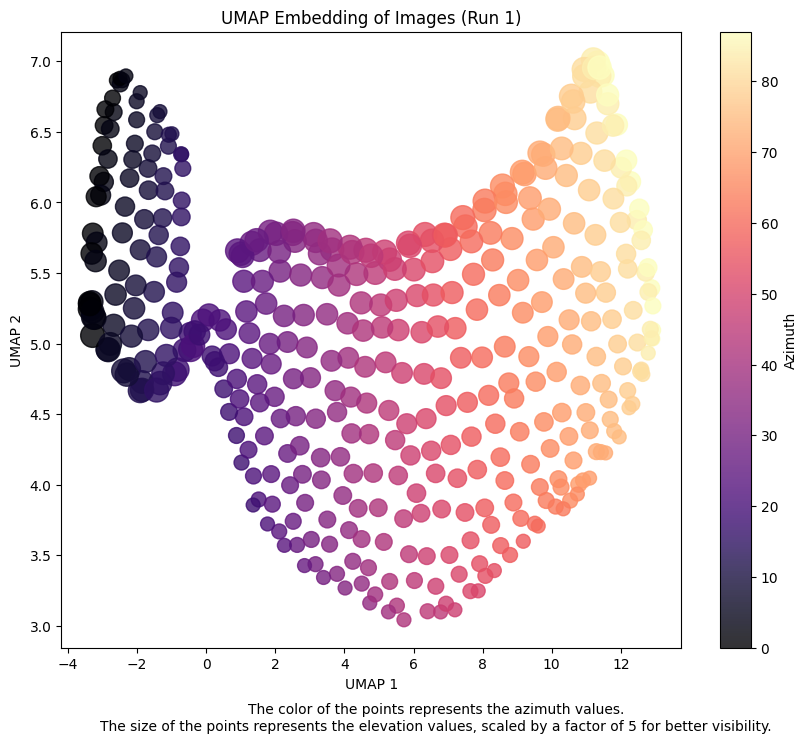

In [34]:
image_vectors = np.array(image_vectors)

umap_embedding = umap.UMAP(n_components=2)
embedding = umap_embedding.fit_transform(image_vectors)

def create_umap_plot(run_number):
    umap_embedding = umap.UMAP(n_components=2, random_state=None)
    embedding = umap_embedding.fit_transform(image_vectors)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=azimuths, cmap='magma', s=np.array(elevations) * 5, alpha=0.8)

    cbar = plt.colorbar(scatter)
    cbar.set_label('Azimuth')

    plt.title(f'UMAP Embedding of Images (Run {run_number})')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')

    plt.figtext(0.5, 0.01, "The color of the points represents the azimuth values.\n"
                           "The size of the points represents the elevation values, scaled by a factor of 5 for better visibility.",
                wrap=True, horizontalalignment='center', fontsize=10)

    plt.show()

create_umap_plot(1)

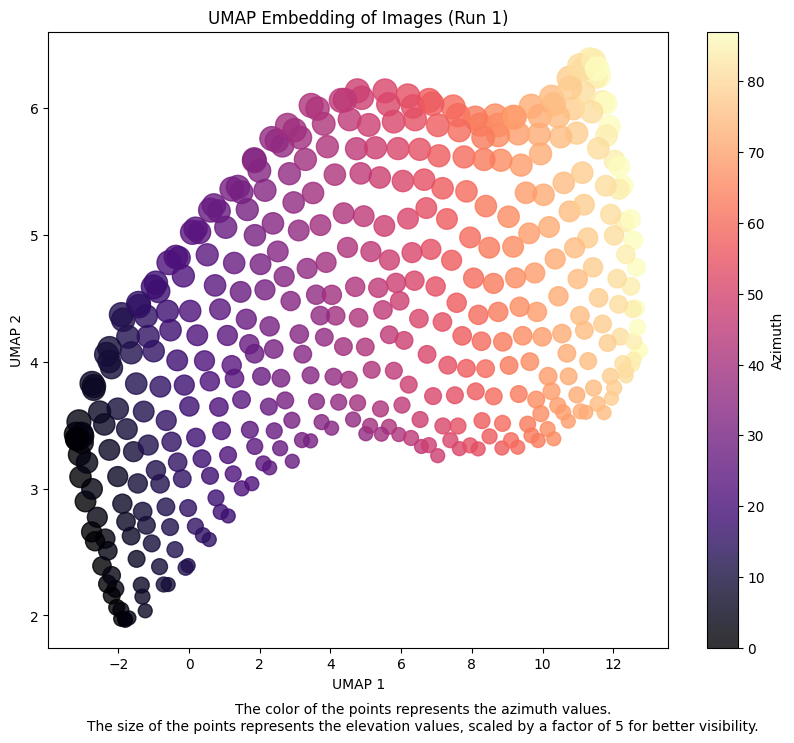

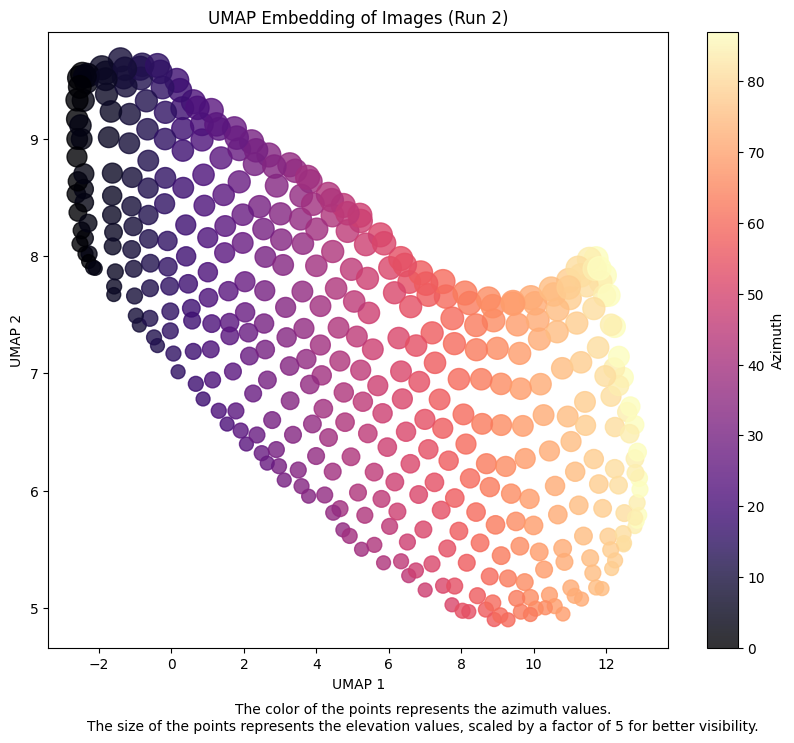

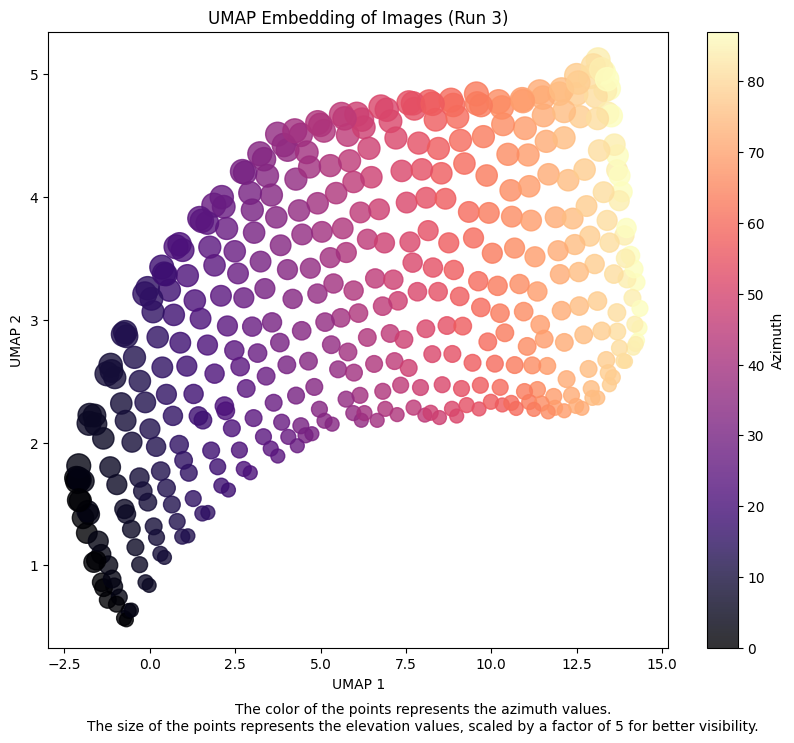

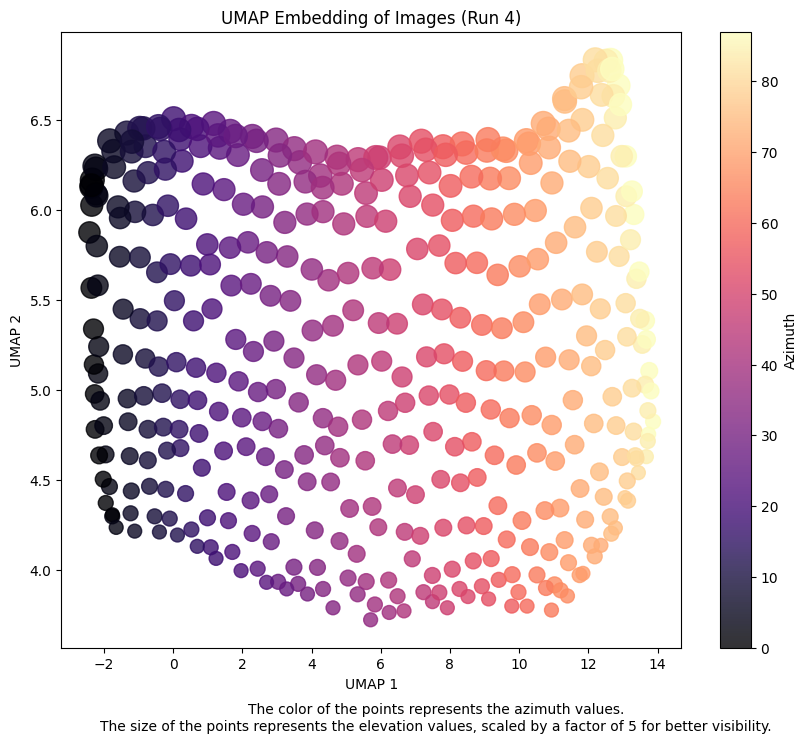

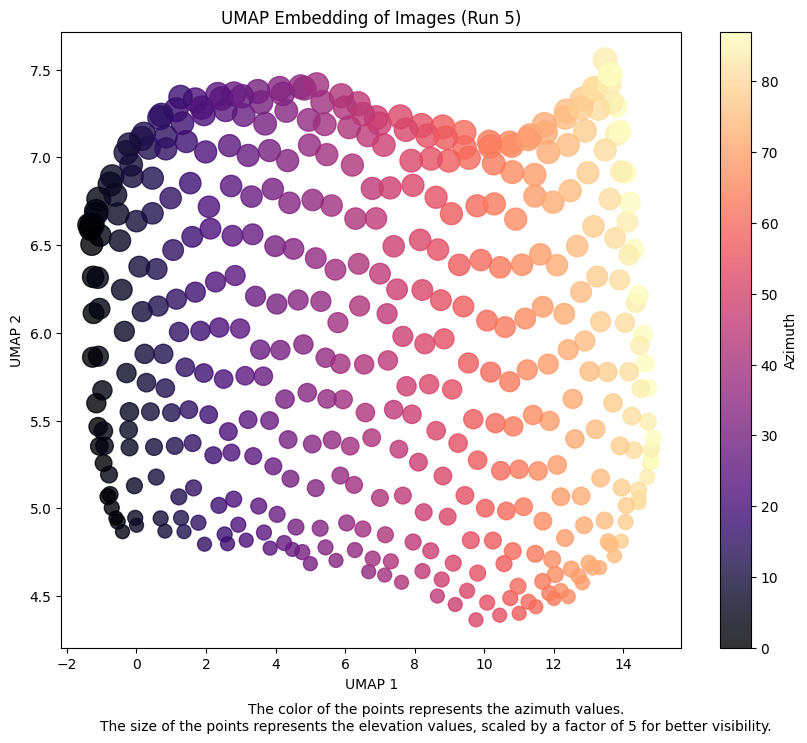

In [35]:
for i in range(1, 6):
    create_umap_plot(i)

Despite the stochastic nature, the overall structure and layout of the embeddings remain somewhat consistent across the different runs. This indicates that UMAP is able to capture the underlying manifold reliably.